<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/Executable_Colab_Notebooks/PFN/PFN_example_pythia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the energyflow and h5py packages in the Colab environment

In [1]:
!pip install energyflow
!pip install h5py

Checking the version of Python (should be Python 3.6)

In [2]:
!python --version

Python 3.6.9


Installing POT (Python Optimal Transform) package

In [3]:
!pip install POT

The following code runs a quark gluon classifier using a PFN (Particle Flow Network) architecture. The input jets are Pythia-generated. The AUC tops out at around 0.90. This model can be trained/validated/tested on more data (up to 900,000 jets in Colab), but we use 220,000 jets total so we can compare it directly to the CNN. Here, we use 165,000 jets to train, 22,000 jets to validate, and and 33,000 jets to test.

Using TensorFlow backend.


Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_1[0][0]           

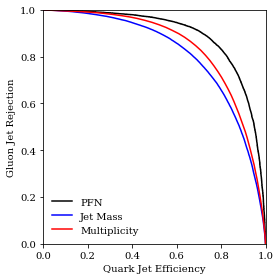

In [4]:
"""An example involving Particle Flow Networks (PFNs), which were 
introduced in [1810.05165](https://arxiv.org/abs/1810.05165). The 
[`PFN`](../docs/archs/#pfn) class is used to construct the 
network architecture. The output of the example is a plot of the 
ROC curves obtained by the PFN as well as the jet mass and 
constituent multiplicity observables.
"""

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matploltib in order to make plots')
    plt = False

################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 165000, 22000, 33000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# load data
X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()